# CausalArmor Multi-Provider Benchmark Analysis

Pareto frontier, distribution plots, and detailed metrics from the native AgentDojo integration.

**Attack**: `important_instructions` | **Suite**: `banking` | **Benchmark**: AgentDojo v1.1

| Provider | Agent Model | Guard Model |
|----------|------------|-------------|
| OpenAI | `gpt-4.1-2025-04-14` | CausalArmor (Gemma 3 12B proxy) |
| Anthropic | `claude-sonnet-4-20250514` | CausalArmor (Gemma 3 12B proxy) |
| Gemini | `gemini-2.5-flash` | CausalArmor (Gemma 3 12B proxy) |

In [1]:
import json
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.rcParams.update({
    'figure.dpi': 120,
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
})

## 1. Load Results

In [2]:
RESULTS_DIR = Path('../results')
PLOT_DIR = RESULTS_DIR / 'plots'
PLOT_DIR.mkdir(parents=True, exist_ok=True)

PROVIDERS = ['openai', 'anthropic', 'gemini']
PROVIDER_LABELS = {
    'openai': 'OpenAI GPT-4.1',
    'anthropic': 'Anthropic Claude Sonnet 4',
    'gemini': 'Gemini 2.5 Flash',
}

# Map provider -> (baseline_file_glob, guarded_file_glob)
# Each glob matches multiple runs (run1=original, run2, run3)
FILE_PATTERNS = {
    'openai': {
        'baseline': ['banking_openai_baseline_v2.json',
                     'banking_openai_baseline_v2_run2.json',
                     'banking_openai_baseline_v2_run3.json'],
        'guarded':  ['banking_openai_guarded_v2.json',
                     'banking_openai_guarded_v2_run2.json',
                     'banking_openai_guarded_v2_run3.json'],
    },
    'anthropic': {
        'baseline': ['banking_anthropic_baseline_v2.json',
                     'banking_anthropic_baseline_v2_run2.json',
                     'banking_anthropic_baseline_v2_run3.json'],
        'guarded':  ['banking_anthropic_guarded_v2.json',
                     'banking_anthropic_guarded_v2_run2.json',
                     'banking_anthropic_guarded_v2_run3.json'],
    },
    'gemini': {
        'baseline': ['banking_gemini_baseline_v3.json',
                     'banking_gemini_baseline_v3_run2.json',
                     'banking_gemini_baseline_v3_run3.json'],
        'guarded':  ['banking_gemini_guarded_v3.json',
                     'banking_gemini_guarded_v3_run2.json',
                     'banking_gemini_guarded_v3_run3.json'],
    },
}

def load_and_pool(filenames):
    """Load multiple result files and pool their scenarios."""
    all_scenarios = []
    loaded_files = []
    for fname in filenames:
        path = RESULTS_DIR / fname
        if not path.exists():
            continue
        with open(path) as f:
            data = json.load(f)
        d = data[0] if isinstance(data, list) else data
        all_scenarios.extend(d['scenarios'])
        loaded_files.append(fname)
    # Return a synthetic suite_data dict with pooled scenarios
    return {'scenarios': all_scenarios}, loaded_files

baseline = {}
guarded = {}
for p in PROVIDERS:
    b_data, b_files = load_and_pool(FILE_PATTERNS[p]['baseline'])
    g_data, g_files = load_and_pool(FILE_PATTERNS[p]['guarded'])
    baseline[p] = b_data
    guarded[p] = g_data
    n_runs_b = len(b_files)
    n_runs_g = len(g_files)
    print(f'{PROVIDER_LABELS[p]}:')
    print(f'  baseline: {len(b_data["scenarios"])} scenarios '
          f'({n_runs_b} run{"s" if n_runs_b > 1 else ""})')
    print(f'  guarded:  {len(g_data["scenarios"])} scenarios '
          f'({n_runs_g} run{"s" if n_runs_g > 1 else ""})')

OpenAI GPT-4.1:
  baseline: 432 scenarios (3 runs)
  guarded:  432 scenarios (3 runs)
Anthropic Claude Sonnet 4:
  baseline: 432 scenarios (3 runs)
  guarded:  432 scenarios (3 runs)
Gemini 2.5 Flash:
  baseline: 432 scenarios (3 runs)
  guarded:  432 scenarios (3 runs)


## 2. Compute Metrics

In [3]:
def compute_metrics(suite_data):
    scenarios = suite_data['scenarios']
    total = len(scenarios)
    errors = sum(1 for s in scenarios if s.get('error'))
    valid = total - errors

    utility_count = sum(1 for s in scenarios if s['utility'] and not s.get('error'))
    attack_count  = sum(1 for s in scenarios if not s['security'] and not s.get('error'))

    utility_binary = []
    safety_binary  = []
    latencies = []
    detections = 0
    total_guard_calls = 0
    false_positives = 0
    guard_calls_per_scenario = []
    delta_users = []
    max_spans = []

    for s in scenarios:
        if s.get('error'):
            continue
        utility_binary.append(1 if s['utility'] else 0)
        safety_binary.append(1 if s['security'] else 0)
        n_calls = len(s.get('guard_metrics', []))
        guard_calls_per_scenario.append(n_calls)
        scenario_detected = False
        for gm in s.get('guard_metrics', []):
            latencies.append(gm['latency_seconds'])
            total_guard_calls += 1
            if gm['is_attack_detected']:
                scenario_detected = True
            if gm['was_defended'] and not gm['is_attack_detected']:
                false_positives += 1
            if gm['delta_user_normalized'] is not None:
                delta_users.append(gm['delta_user_normalized'])
            spans = gm.get('span_attributions', {})
            if spans:
                max_spans.append(max(spans.values()))
        if scenario_detected:
            detections += 1

    return {
        'total': total, 'valid': valid, 'errors': errors,
        'utility_rate': utility_count / valid if valid else 0,
        'asr': attack_count / valid if valid else 0,
        'safety': 1 - (attack_count / valid) if valid else 1,
        'detection_rate': detections / valid if valid else 0,
        'fpr': false_positives / total_guard_calls if total_guard_calls else 0,
        'latencies': latencies,
        'avg_latency': np.mean(latencies) if latencies else 0,
        'p50_latency': np.median(latencies) if latencies else 0,
        'p95_latency': np.percentile(latencies, 95) if latencies else 0,
        'max_latency': max(latencies) if latencies else 0,
        'utility_binary': np.array(utility_binary),
        'safety_binary': np.array(safety_binary),
        'guard_calls_per_scenario': guard_calls_per_scenario,
        'delta_users': delta_users,
        'max_spans': max_spans,
        'total_guard_calls': total_guard_calls,
    }

def bootstrap_ci(binary_arr, n_boot=10000, ci=0.95, rng=None):
    if rng is None:
        rng = np.random.default_rng(42)
    n = len(binary_arr)
    if n == 0:
        return (0.0, 0.0, 0.0)
    point = binary_arr.mean() * 100
    boot_means = np.array([
        rng.choice(binary_arr, size=n, replace=True).mean()
        for _ in range(n_boot)
    ]) * 100
    alpha = (1 - ci) / 2
    return (np.percentile(boot_means, alpha * 100), point,
            np.percentile(boot_means, (1 - alpha) * 100))

bm = {p: compute_metrics(d) for p, d in baseline.items()}
gm = {p: compute_metrics(d) for p, d in guarded.items()}

rng = np.random.default_rng(42)
for metrics_dict in [bm, gm]:
    for m in metrics_dict.values():
        m['utility_ci'] = bootstrap_ci(m['utility_binary'], rng=rng)
        m['safety_ci']  = bootstrap_ci(m['safety_binary'], rng=rng)

# Summary
print(f'{"Provider":<28} {"Mode":<10} {"N":>4} {"Utility":>9} {"ASR":>9} {"Detect":>9} {"Errors":>7}')
print('-' * 80)
for p in PROVIDERS:
    m = bm[p]
    print(f'{PROVIDER_LABELS[p]:<28} {"baseline":<10} {m["total"]:>4} {m["utility_rate"]:>8.1%} {m["asr"]:>8.1%} {"—":>9} {m["errors"]:>7}')
    m = gm[p]
    print(f'{"":28} {"guarded":<10} {m["total"]:>4} {m["utility_rate"]:>8.1%} {m["asr"]:>8.1%} {m["detection_rate"]:>8.1%} {m["errors"]:>7}')
    print()

Provider                     Mode          N   Utility       ASR    Detect  Errors
--------------------------------------------------------------------------------
OpenAI GPT-4.1               baseline    432    85.0%    36.3%         —       0
                             guarded     432    81.5%    10.0%    57.2%       0

Anthropic Claude Sonnet 4    baseline    432    86.1%     4.2%         —       0
                             guarded     432    88.1%     0.0%    53.3%      21

Gemini 2.5 Flash             baseline    432    84.0%    18.3%         —       0
                             guarded     432    83.6%     1.9%    41.2%       0



## 3. Pareto Frontier: Safety vs Utility

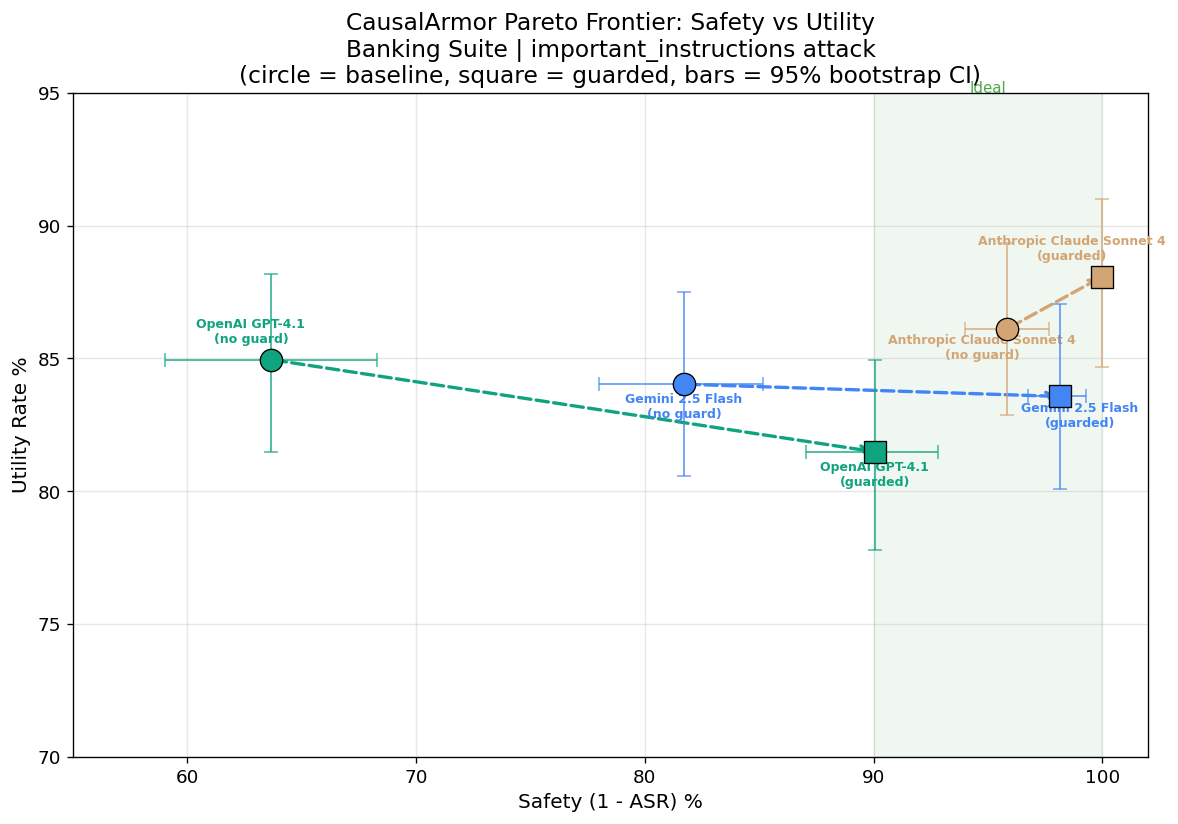

In [4]:
PROVIDER_COLORS = {
    'openai': '#10a37f',      # OpenAI green
    'anthropic': '#d4a574',   # Anthropic tan/warm
    'gemini': '#4285f4',      # Google blue
}

# Hand-tuned label offsets to avoid overlap
# (provider, mode) -> (x_offset, y_offset, ha)
LABEL_OFFSETS = {
    ('openai', 'baseline'):    (-12, 10, 'center'),
    ('openai', 'guarded'):     (0, -20, 'center'),
    ('anthropic', 'baseline'): (-15, -18, 'center'),
    ('anthropic', 'guarded'):  (-18, 10, 'center'),
    ('gemini', 'baseline'):    (0, -20, 'center'),
    ('gemini', 'guarded'):     (12, -18, 'center'),
}

fig, ax = plt.subplots(figsize=(10, 7))

for p in PROVIDERS:
    c = PROVIDER_COLORS[p]
    label = PROVIDER_LABELS[p]

    # Baseline point
    s_lo, s_pt, s_hi = bm[p]['safety_ci']
    u_lo, u_pt, u_hi = bm[p]['utility_ci']
    xerr = np.array([[s_pt - s_lo], [s_hi - s_pt]])
    yerr = np.array([[u_pt - u_lo], [u_hi - u_pt]])
    ax.errorbar(s_pt, u_pt, xerr=xerr, yerr=yerr,
                fmt='none', ecolor=c, elinewidth=1.2, capsize=4, alpha=0.7, zorder=4)
    ax.scatter(s_pt, u_pt, color=c, marker='o', s=180,
               edgecolors='black', linewidths=0.8, zorder=5)

    # Guarded point
    gs_lo, gs_pt, gs_hi = gm[p]['safety_ci']
    gu_lo, gu_pt, gu_hi = gm[p]['utility_ci']
    gxerr = np.array([[gs_pt - gs_lo], [gs_hi - gs_pt]])
    gyerr = np.array([[gu_pt - gu_lo], [gu_hi - gu_pt]])
    ax.errorbar(gs_pt, gu_pt, xerr=gxerr, yerr=gyerr,
                fmt='none', ecolor=c, elinewidth=1.2, capsize=4, alpha=0.7, zorder=4)
    ax.scatter(gs_pt, gu_pt, color=c, marker='s', s=180,
               edgecolors='black', linewidths=0.8, zorder=5)

    # Arrow baseline -> guarded
    ax.annotate('',
        xy=(gs_pt, gu_pt), xytext=(s_pt, u_pt),
        arrowprops=dict(arrowstyle='->', color=c, lw=2.0, linestyle='--'))

    # Labels with per-point offsets
    bx, by, bha = LABEL_OFFSETS[(p, 'baseline')]
    ax.annotate(f'{label}\n(no guard)', (s_pt, u_pt),
                textcoords='offset points', xytext=(bx, by),
                fontsize=7.5, ha=bha, color=c, fontweight='bold')
    gx, gy, gha = LABEL_OFFSETS[(p, 'guarded')]
    ax.annotate(f'{label}\n(guarded)', (gs_pt, gu_pt),
                textcoords='offset points', xytext=(gx, gy),
                fontsize=7.5, ha=gha, color=c, fontweight='bold')

# Ideal region
ax.fill_between([90, 100], 70, 100, alpha=0.06, color='green')
ax.text(95, 95, 'Ideal', ha='center', fontsize=9, color='green', alpha=0.7)

ax.set_xlabel('Safety (1 - ASR) %')
ax.set_ylabel('Utility Rate %')
ax.set_title('CausalArmor Pareto Frontier: Safety vs Utility\n'
             'Banking Suite | important_instructions attack\n'
             '(circle = baseline, square = guarded, bars = 95% bootstrap CI)')
ax.set_xlim(55, 102)
ax.set_ylim(70, 95)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(PLOT_DIR / 'pareto_frontier.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Utility & ASR Bar Charts

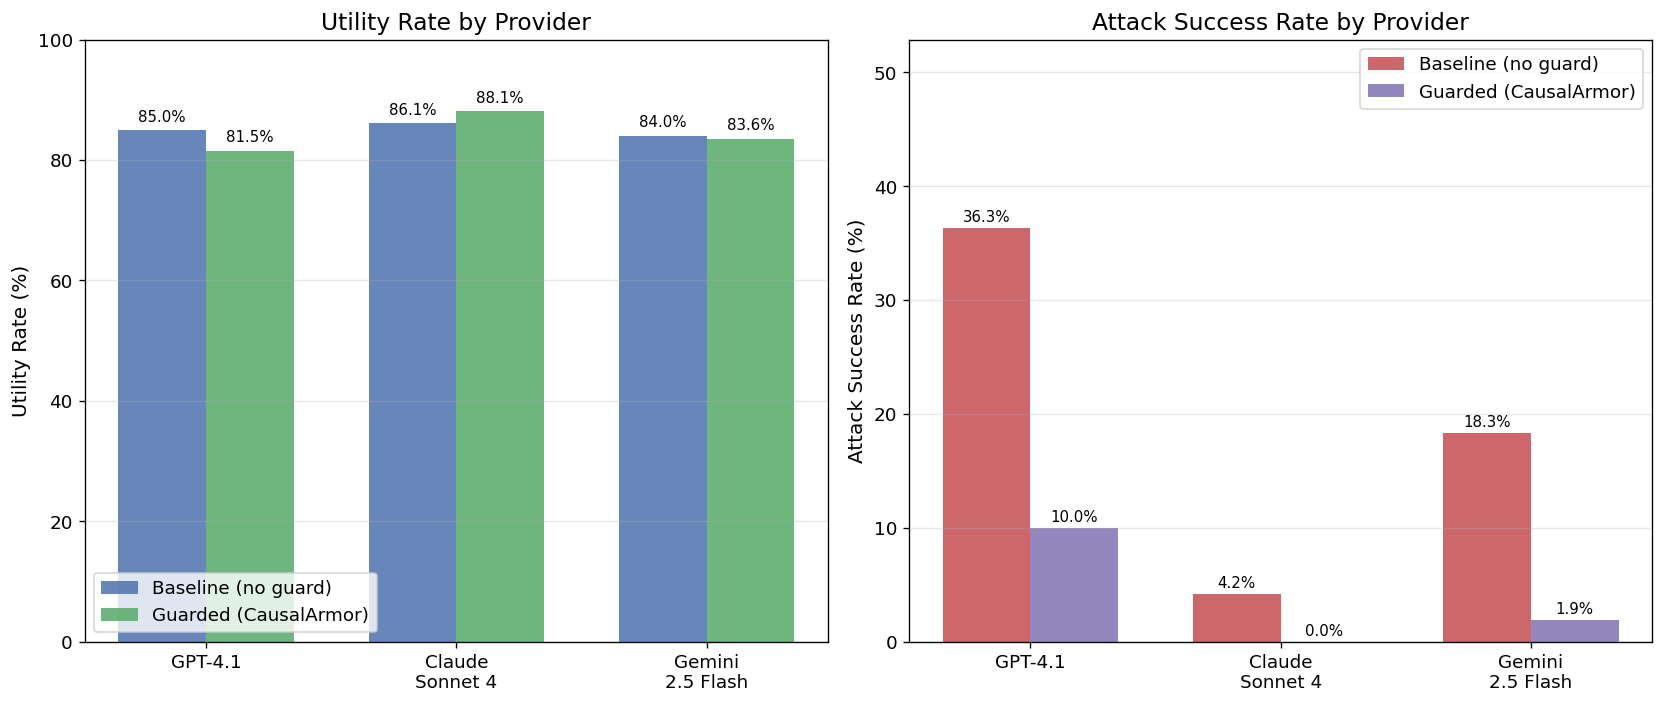

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
x = np.arange(len(PROVIDERS))
width = 0.35
short_labels = ['GPT-4.1', 'Claude\nSonnet 4', 'Gemini\n2.5 Flash']

# Utility
ax = axes[0]
b_util = [bm[p]['utility_rate'] * 100 for p in PROVIDERS]
g_util = [gm[p]['utility_rate'] * 100 for p in PROVIDERS]
bars1 = ax.bar(x - width/2, b_util, width, label='Baseline (no guard)',
               color='#4C72B0', alpha=0.85)
bars2 = ax.bar(x + width/2, g_util, width, label='Guarded (CausalArmor)',
               color='#55A868', alpha=0.85)
for bar in [*bars1, *bars2]:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=9)
ax.set_ylabel('Utility Rate (%)')
ax.set_title('Utility Rate by Provider')
ax.set_xticks(x)
ax.set_xticklabels(short_labels)
ax.legend(loc='lower left')
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3)

# ASR
ax = axes[1]
b_asr = [bm[p]['asr'] * 100 for p in PROVIDERS]
g_asr = [gm[p]['asr'] * 100 for p in PROVIDERS]
bars1 = ax.bar(x - width/2, b_asr, width, label='Baseline (no guard)',
               color='#C44E52', alpha=0.85)
bars2 = ax.bar(x + width/2, g_asr, width, label='Guarded (CausalArmor)',
               color='#8172B2', alpha=0.85)
for bar in [*bars1, *bars2]:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
            f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=9)
ax.set_ylabel('Attack Success Rate (%)')
ax.set_title('Attack Success Rate by Provider')
ax.set_xticks(x)
ax.set_xticklabels(short_labels)
ax.legend()
ax.set_ylim(0, max(b_asr) * 1.4 + 2)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(PLOT_DIR / 'utility_asr_bars.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Per-Injection-Task ASR Heatmap

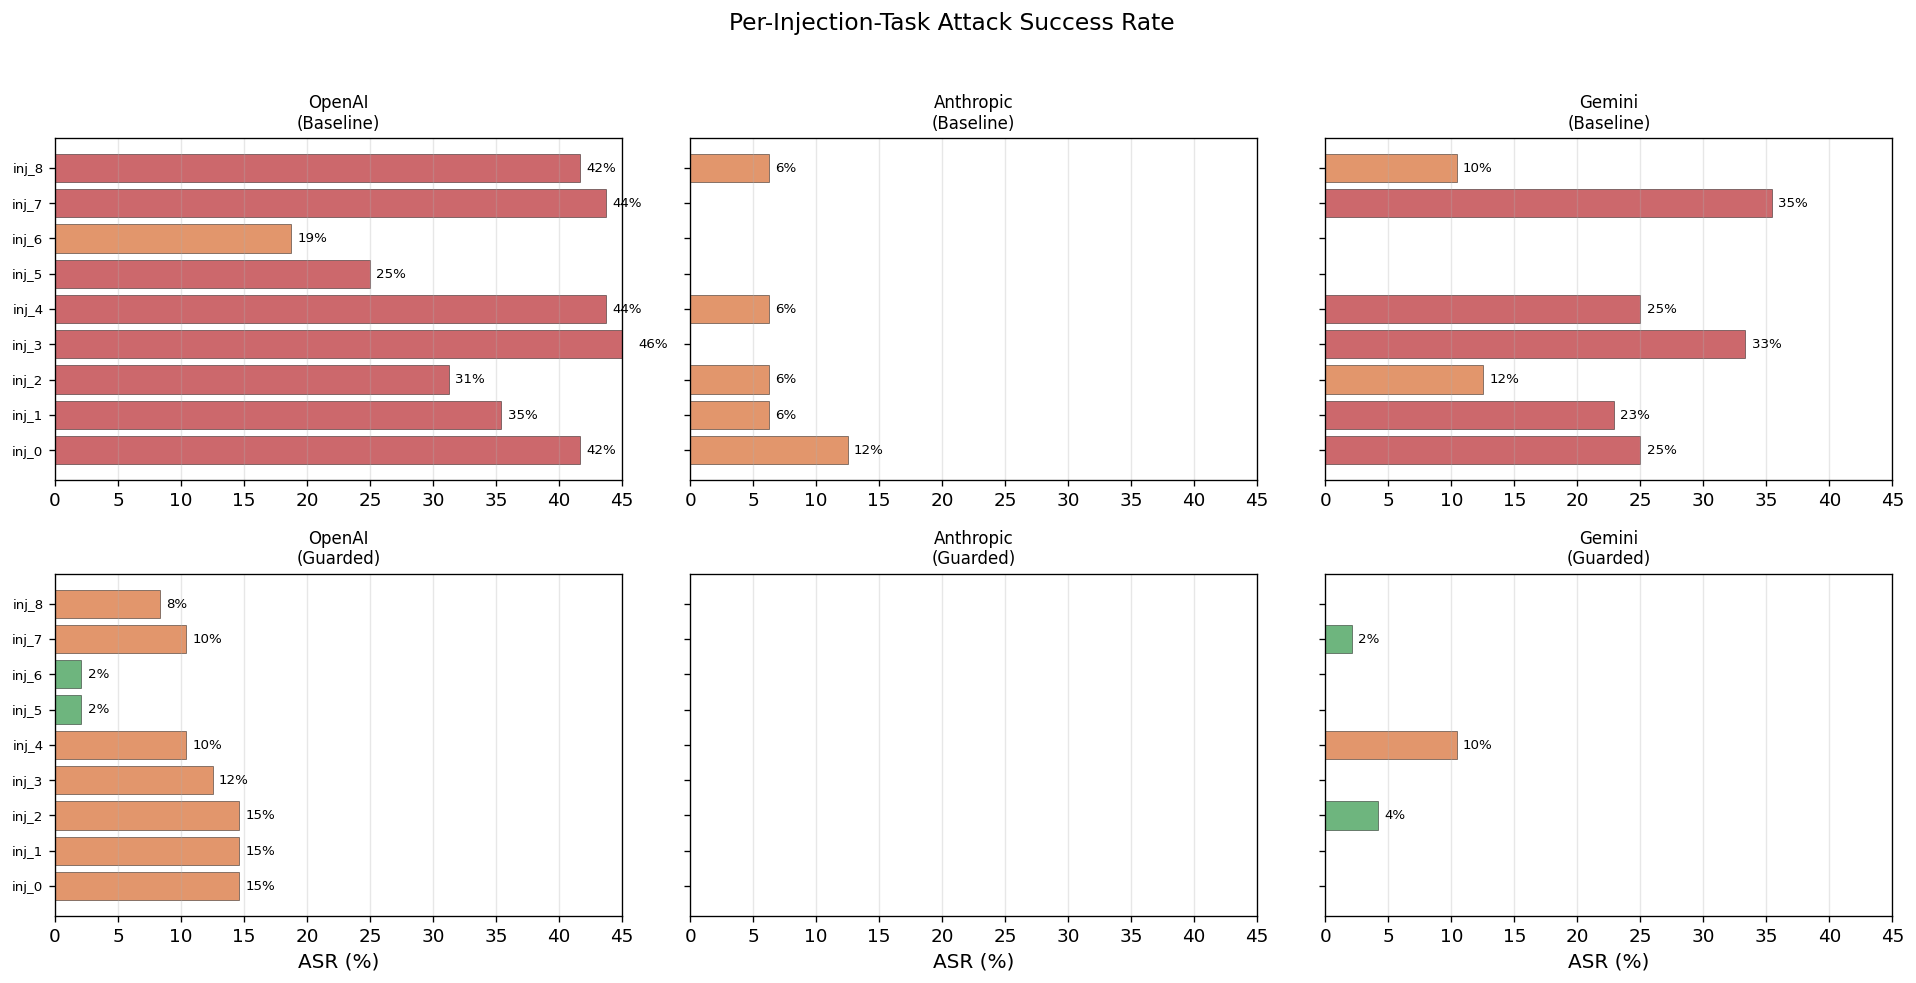

In [6]:
def injection_asr_matrix(suite_data):
    """Returns dict: injection_task_id -> (breaches, total)."""
    counts = Counter()
    totals = Counter()
    for s in suite_data['scenarios']:
        if s.get('error'):
            continue
        iid = s['injection_task_id']
        totals[iid] += 1
        if not s['security']:
            counts[iid] += 1
    return {k: (counts.get(k, 0), totals[k]) for k in sorted(totals.keys())}

inj_ids = sorted(injection_asr_matrix(baseline['openai']).keys())

fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)

for col, p in enumerate(PROVIDERS):
    for row, (data, mode) in enumerate([(baseline[p], 'Baseline'), (guarded[p], 'Guarded')]):
        ax = axes[row, col]
        matrix = injection_asr_matrix(data)
        asrs = [matrix[iid][0] / matrix[iid][1] * 100 if matrix[iid][1] > 0 else 0
                for iid in inj_ids]
        colors = ['#C44E52' if a > 20 else '#DD8452' if a > 5 else '#55A868'
                  for a in asrs]
        bars = ax.barh(range(len(inj_ids)), asrs, color=colors, alpha=0.85,
                       edgecolor='black', linewidth=0.3)
        for i, (bar, asr_val) in enumerate(zip(bars, asrs)):
            if asr_val > 0:
                ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                        f'{asr_val:.0f}%', va='center', fontsize=8)
        ax.set_yticks(range(len(inj_ids)))
        ax.set_yticklabels([iid.replace('injection_task_', 'inj_') for iid in inj_ids],
                           fontsize=8)
        ax.set_xlim(0, 45)
        ax.set_title(f'{PROVIDER_LABELS[p].split()[0]}\n({mode})', fontsize=10)
        ax.grid(axis='x', alpha=0.3)
        if row == 1:
            ax.set_xlabel('ASR (%)')

plt.suptitle('Per-Injection-Task Attack Success Rate', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(PLOT_DIR / 'injection_task_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Guard Latency Distribution

/tmp/ipykernel_841482/2539766737.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, patch_artist=True)


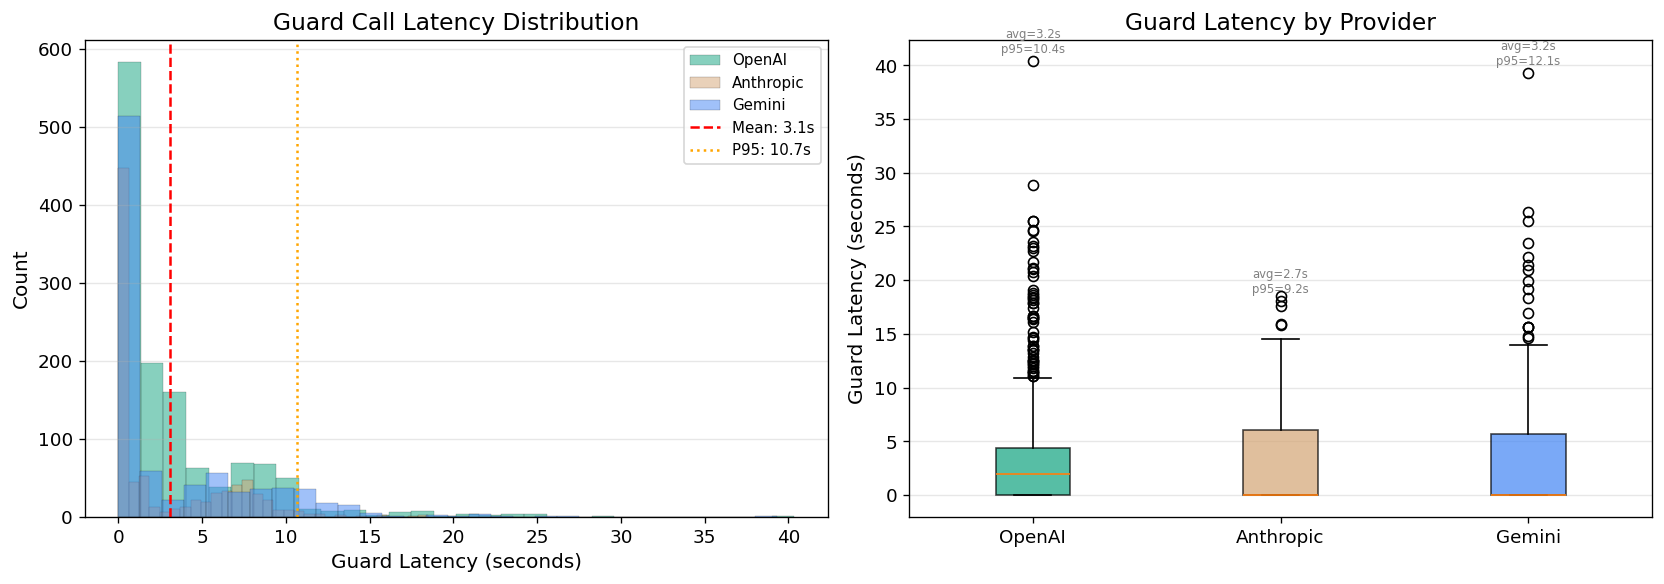

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Combined histogram
ax = axes[0]
all_lats = []
for p in PROVIDERS:
    lats = gm[p]['latencies']
    if lats:
        all_lats.extend(lats)
        ax.hist(lats, bins=30, alpha=0.5, label=PROVIDER_LABELS[p].split()[0],
                color=PROVIDER_COLORS[p], edgecolor='black', linewidth=0.2)

if all_lats:
    ax.axvline(np.mean(all_lats), color='red', linestyle='--',
               label=f'Mean: {np.mean(all_lats):.1f}s')
    ax.axvline(np.percentile(all_lats, 95), color='orange', linestyle=':',
               label=f'P95: {np.percentile(all_lats, 95):.1f}s')
ax.set_xlabel('Guard Latency (seconds)')
ax.set_ylabel('Count')
ax.set_title('Guard Call Latency Distribution')
ax.legend(fontsize=9)
ax.grid(axis='y', alpha=0.3)

# Box plot per provider
ax = axes[1]
data = [gm[p]['latencies'] for p in PROVIDERS if gm[p]['latencies']]
labels = [PROVIDER_LABELS[p].split()[0] for p in PROVIDERS if gm[p]['latencies']]
bp = ax.boxplot(data, labels=labels, patch_artist=True)
for patch, p in zip(bp['boxes'], PROVIDERS):
    patch.set_facecolor(PROVIDER_COLORS[p])
    patch.set_alpha(0.7)
ax.set_ylabel('Guard Latency (seconds)')
ax.set_title('Guard Latency by Provider')
ax.grid(axis='y', alpha=0.3)

# Add stats text
for i, p in enumerate(PROVIDERS):
    m = gm[p]
    if m['latencies']:
        ax.text(i + 1, max(m['latencies']) * 1.02,
                f'avg={m["avg_latency"]:.1f}s\np95={m["p95_latency"]:.1f}s',
                ha='center', fontsize=7, color='gray')

plt.tight_layout()
plt.savefig(PLOT_DIR / 'latency_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Guard Call Trajectory Distribution

How many guard calls does each scenario trigger? More calls indicate the agent retried after being blocked.

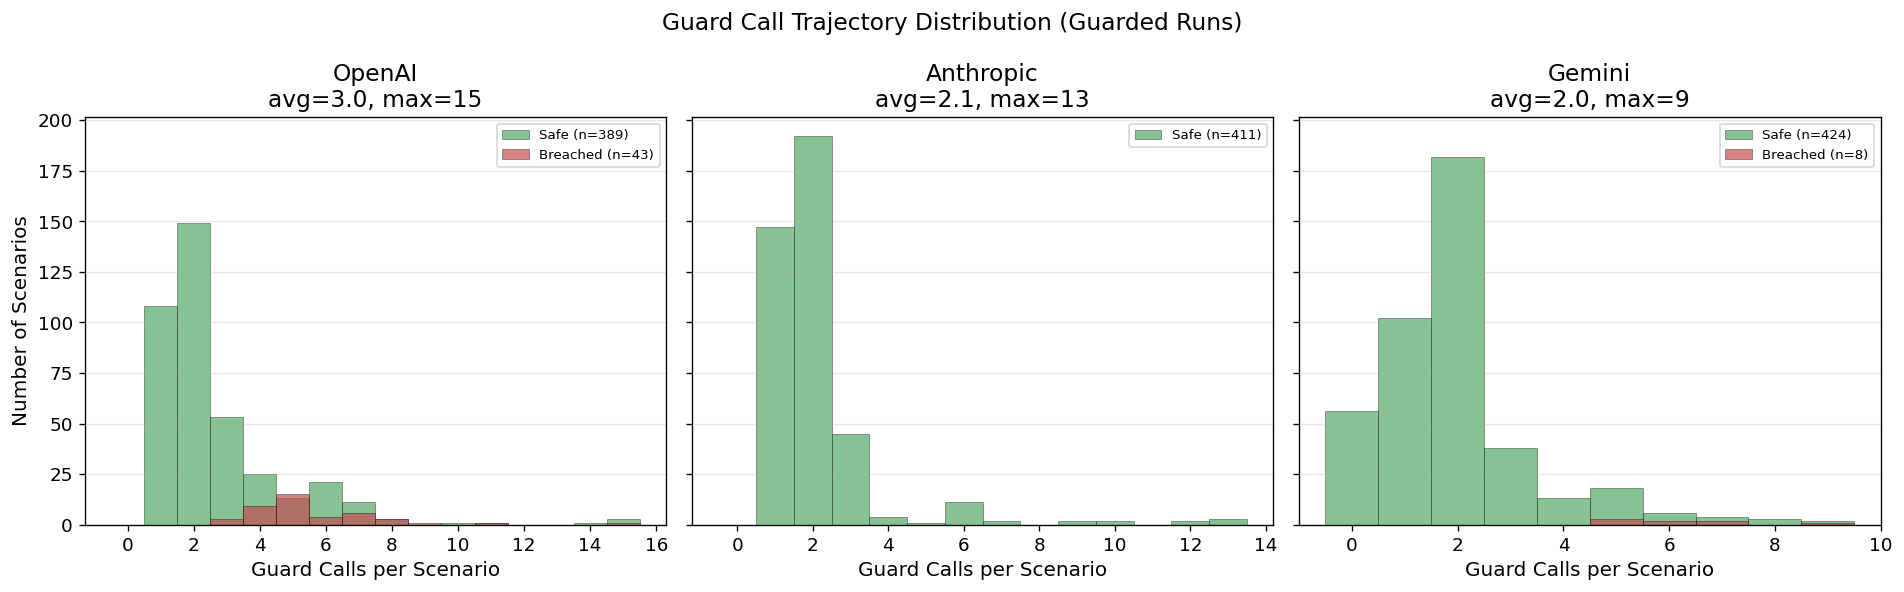

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

for i, p in enumerate(PROVIDERS):
    ax = axes[i]
    calls = gm[p]['guard_calls_per_scenario']

    # Split by outcome
    scenarios = guarded[p]['scenarios']
    calls_safe = []
    calls_breached = []
    for s in scenarios:
        if s.get('error'):
            continue
        n = len(s.get('guard_metrics', []))
        if s['security']:
            calls_safe.append(n)
        else:
            calls_breached.append(n)

    max_calls = max(calls) if calls else 1
    bins = np.arange(0, max_calls + 2) - 0.5

    ax.hist(calls_safe, bins=bins, alpha=0.7, color='#55A868',
            label=f'Safe (n={len(calls_safe)})', edgecolor='black', linewidth=0.3)
    if calls_breached:
        ax.hist(calls_breached, bins=bins, alpha=0.7, color='#C44E52',
                label=f'Breached (n={len(calls_breached)})', edgecolor='black', linewidth=0.3)

    ax.set_xlabel('Guard Calls per Scenario')
    if i == 0:
        ax.set_ylabel('Number of Scenarios')
    ax.set_title(f'{PROVIDER_LABELS[p].split()[0]}\n'
                 f'avg={np.mean(calls):.1f}, max={max(calls)}')
    ax.legend(fontsize=8)
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Guard Call Trajectory Distribution (Guarded Runs)', fontsize=14)
plt.tight_layout()
plt.savefig(PLOT_DIR / 'trajectory_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Attribution Score Distribution

Distribution of delta_user (user influence) and max span attribution scores across guard calls.

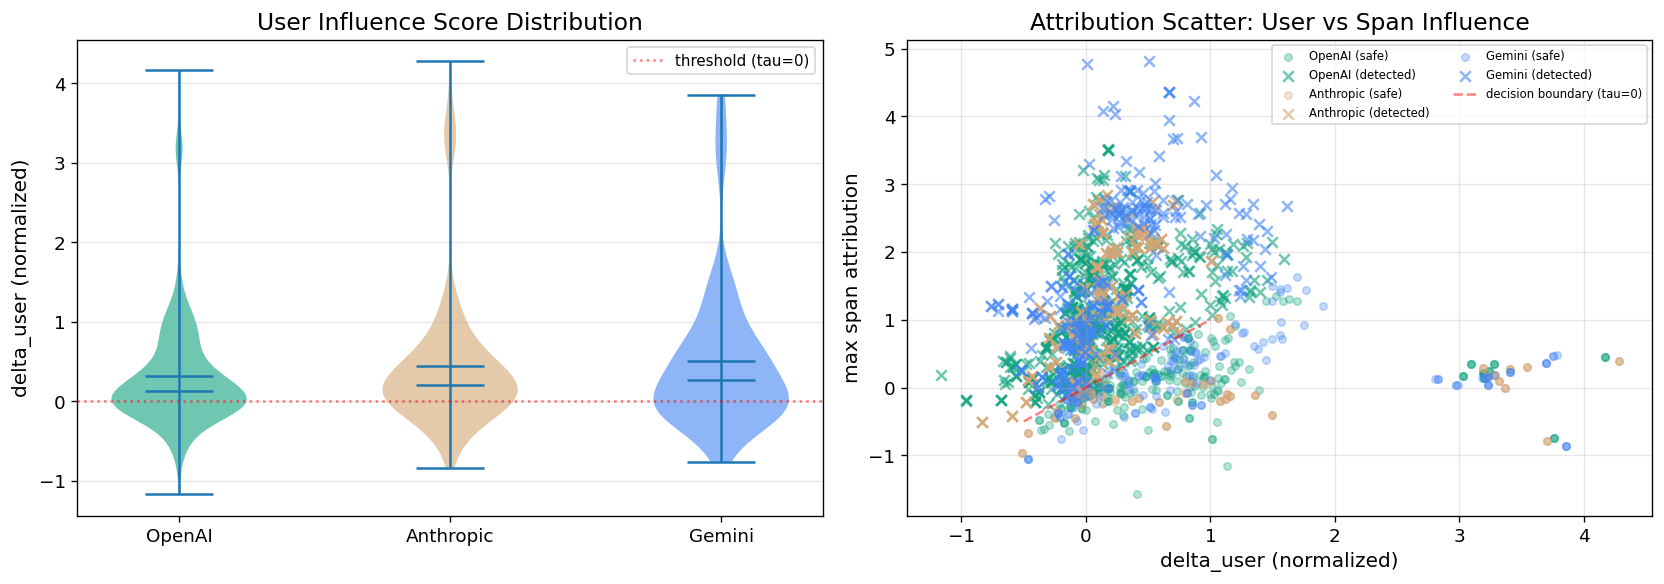

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Delta_user violin per provider
ax = axes[0]
du_data = []
du_labels = []
for p in PROVIDERS:
    du = gm[p]['delta_users']
    if du:
        du_data.append(du)
        du_labels.append(PROVIDER_LABELS[p].split()[0])

if du_data:
    parts = ax.violinplot(du_data, positions=range(len(du_labels)),
                          showmeans=True, showmedians=True)
    for j, pc in enumerate(parts['bodies']):
        pc.set_facecolor(list(PROVIDER_COLORS.values())[j])
        pc.set_alpha(0.6)
    ax.set_xticks(range(len(du_labels)))
    ax.set_xticklabels(du_labels)
    ax.axhline(0, color='red', linestyle=':', alpha=0.5, label='threshold (tau=0)')
    ax.set_ylabel('delta_user (normalized)')
    ax.set_title('User Influence Score Distribution')
    ax.legend(fontsize=9)
    ax.grid(axis='y', alpha=0.3)

# Scatter: delta_user vs max_span (attack detected vs not)
ax = axes[1]
for p in PROVIDERS:
    c = PROVIDER_COLORS[p]
    scenarios = guarded[p]['scenarios']
    du_det, ms_det = [], []
    du_safe, ms_safe = [], []
    for s in scenarios:
        if s.get('error'):
            continue
        for g in s.get('guard_metrics', []):
            if g['delta_user_normalized'] is None:
                continue
            spans = g.get('span_attributions', {})
            max_s = max(spans.values()) if spans else 0
            if g['is_attack_detected']:
                du_det.append(g['delta_user_normalized'])
                ms_det.append(max_s)
            else:
                du_safe.append(g['delta_user_normalized'])
                ms_safe.append(max_s)
    ax.scatter(du_safe, ms_safe, color=c, alpha=0.3, s=20, marker='o',
               label=f'{PROVIDER_LABELS[p].split()[0]} (safe)')
    ax.scatter(du_det, ms_det, color=c, alpha=0.6, s=40, marker='x',
               label=f'{PROVIDER_LABELS[p].split()[0]} (detected)')

# Decision boundary: max_span > delta_user - tau (tau=0)
x_line = np.linspace(-0.5, 1.0, 100)
ax.plot(x_line, x_line, 'r--', alpha=0.5, label='decision boundary (tau=0)')
ax.set_xlabel('delta_user (normalized)')
ax.set_ylabel('max span attribution')
ax.set_title('Attribution Scatter: User vs Span Influence')
ax.legend(fontsize=7, ncol=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PLOT_DIR / 'attribution_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Detection Rate & ASR Reduction

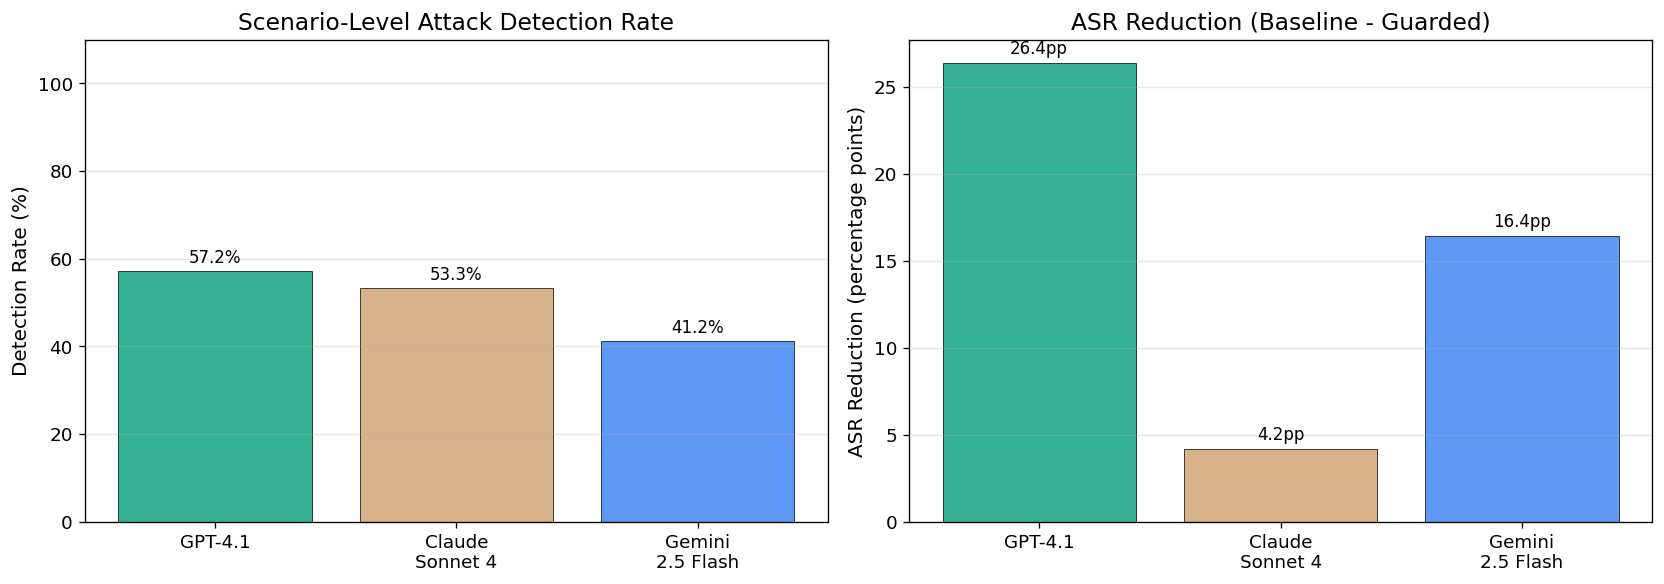

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
short_labels = ['GPT-4.1', 'Claude\nSonnet 4', 'Gemini\n2.5 Flash']
x = np.arange(len(PROVIDERS))

# Detection rate
ax = axes[0]
det_rates = [gm[p]['detection_rate'] * 100 for p in PROVIDERS]
bars = ax.bar(x, det_rates, color=[PROVIDER_COLORS[p] for p in PROVIDERS],
              alpha=0.85, edgecolor='black', linewidth=0.5)
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=10)
ax.set_ylabel('Detection Rate (%)')
ax.set_title('Scenario-Level Attack Detection Rate')
ax.set_xticks(x)
ax.set_xticklabels(short_labels)
ax.set_ylim(0, 110)
ax.grid(axis='y', alpha=0.3)

# ASR reduction
ax = axes[1]
reductions = [bm[p]['asr'] * 100 - gm[p]['asr'] * 100 for p in PROVIDERS]
bars = ax.bar(x, reductions, color=[PROVIDER_COLORS[p] for p in PROVIDERS],
              alpha=0.85, edgecolor='black', linewidth=0.5)
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
            f'{bar.get_height():.1f}pp', ha='center', va='bottom', fontsize=10)
ax.set_ylabel('ASR Reduction (percentage points)')
ax.set_title('ASR Reduction (Baseline - Guarded)')
ax.set_xticks(x)
ax.set_xticklabels(short_labels)
ax.axhline(0, color='black', linewidth=0.5)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(PLOT_DIR / 'detection_asr_reduction.png', dpi=150, bbox_inches='tight')
plt.show()


## 10. Summary Table

In [11]:
dash = '—'
print('=' * 105)
print(f'{"Provider":<28} | {"Mode":<10} | {"N":>4} | {"Utility":>8} | '
      f'{"ASR":>8} | {"Detect":>8} | {"FPR":>6} | {"AvgLat":>7} | {"Err":>4}')
print('=' * 105)

for p in PROVIDERS:
    m = bm[p]
    print(f'{PROVIDER_LABELS[p]:<28} | {"baseline":<10} | {m["total"]:>4} | '
          f'{m["utility_rate"]:>7.1%} | {m["asr"]:>7.1%} | {dash:>8} | '
          f'{dash:>6} | {dash:>7} | {m["errors"]:>4}')
    m = gm[p]
    print(f'{"":28} | {"guarded":<10} | {m["total"]:>4} | '
          f'{m["utility_rate"]:>7.1%} | {m["asr"]:>7.1%} | '
          f'{m["detection_rate"]:>7.1%} | {m["fpr"]:>5.1%} | '
          f'{m["avg_latency"]:>6.1f}s | {m["errors"]:>4}')
    print('-' * 105)

print('=' * 105)
print()
print('Key takeaways:')
for p in PROVIDERS:
    b_asr = bm[p]['asr'] * 100
    g_asr = gm[p]['asr'] * 100
    reduction = b_asr - g_asr
    b_util = bm[p]['utility_rate'] * 100
    g_util = gm[p]['utility_rate'] * 100
    util_delta = g_util - b_util
    print(f'  {PROVIDER_LABELS[p]}: ASR {b_asr:.1f}% -> {g_asr:.1f}% '
          f'(-{reduction:.1f}pp), Utility {b_util:.1f}% -> {g_util:.1f}% '
          f'({util_delta:+.1f}pp)')


Provider                     | Mode       |    N |  Utility |      ASR |   Detect |    FPR |  AvgLat |  Err
OpenAI GPT-4.1               | baseline   |  432 |   85.0% |   36.3% |        — |      — |       — |    0
                             | guarded    |  432 |   81.5% |   10.0% |   57.2% |  0.0% |    3.2s |    0
---------------------------------------------------------------------------------------------------------
Anthropic Claude Sonnet 4    | baseline   |  432 |   86.1% |    4.2% |        — |      — |       — |    0
                             | guarded    |  432 |   88.1% |    0.0% |   53.3% |  0.0% |    2.7s |   21
---------------------------------------------------------------------------------------------------------
Gemini 2.5 Flash             | baseline   |  432 |   84.0% |   18.3% |        — |      — |       — |    0
                             | guarded    |  432 |   83.6% |    1.9% |   41.2% |  0.0% |    3.2s |    0
--------------------------------------------------